# Мэтчинг товаров
Задачи:
- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5.
*деплой: разработать REST API сервис, который по предложенным данным будем предлагать несколько похожих товаров.

🔹 Ссылка на датасет: 

https://disk.yandex.ru/d/BBEphK0EHSJ5Jw

🔺 Описание:

- base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

- train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

- validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

- validation_answer.csv - правильные ответы к предыдущему файлу

## Импортирование

In [8]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [9]:
base_full = pd.read_csv('/Users/artemmm/Downloads/data/base.csv')
base = base_full.copy()
train = pd.read_csv('/Users/artemmm/Downloads/data/train.csv')
validation_answer = pd.read_csv('/Users/artemmm/Downloads/data/validation_answer.csv')
validation = pd.read_csv('/Users/artemmm/Downloads/data/validation.csv')

## EDA

In [10]:
train.head()

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [11]:
base.head()

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3,3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4,4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [12]:
base_full.head()

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3,3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4,4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [13]:
validation.head()

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


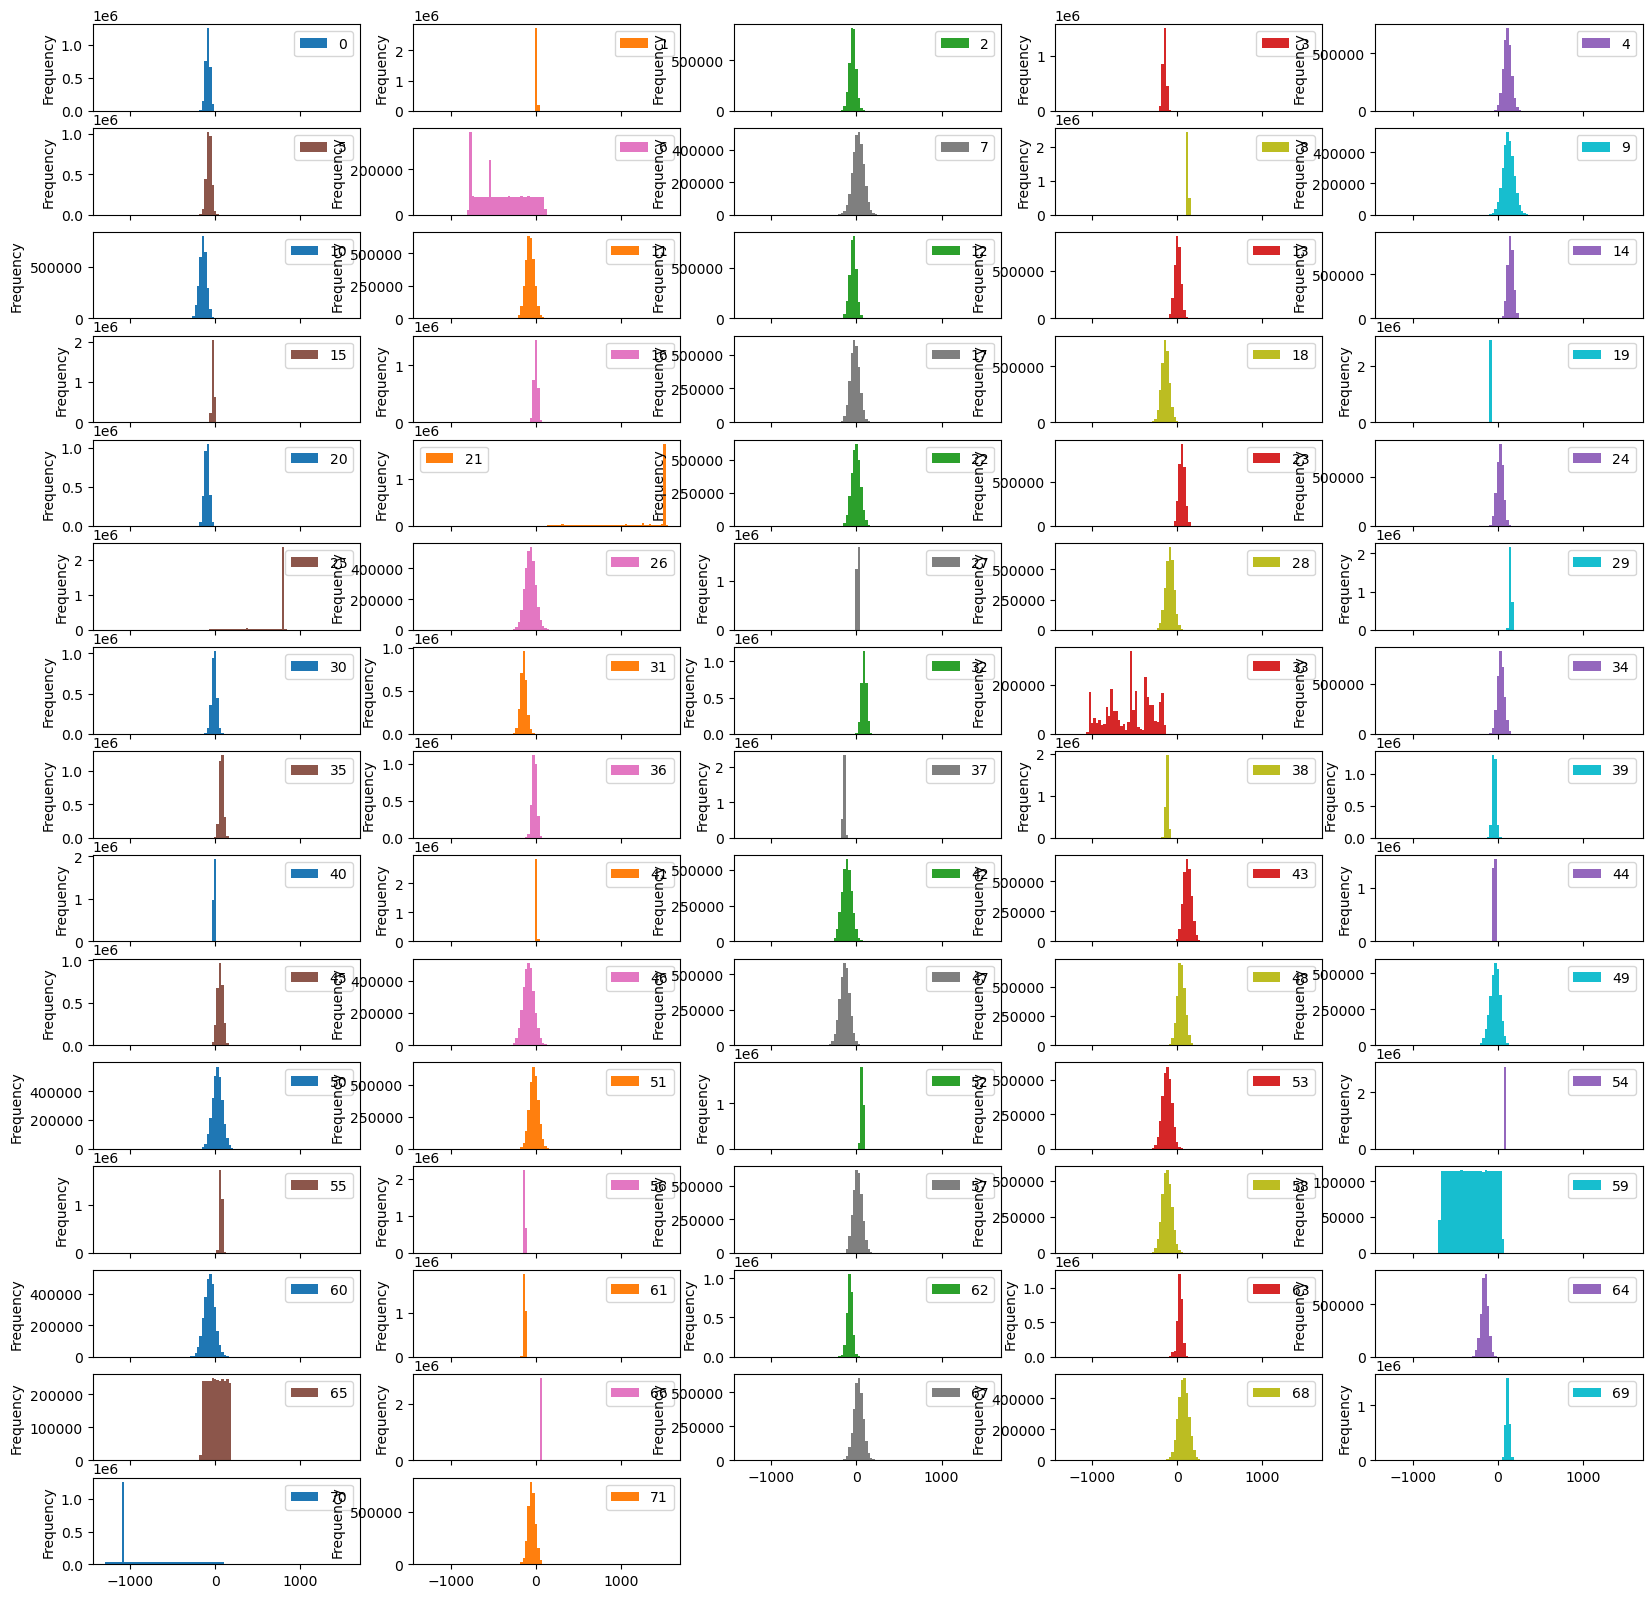

In [14]:
base.plot(kind='hist', figsize=(20, 20), subplots=True, layout=(15, 5), bins=100);

70, 33, 6, 19, 21, 25, 40,41 ,54,55, 59 удалим, тк ненормальное распределение

In [15]:
train = train.drop(['8','33','70', '19', '25', '40', '54', '59', '66', '6', '27', '44', '65', '21', '29', '41', 
                    '52', '56', '61'], axis = 1)
base = base.drop(['8','33','70', '19', '25', '40', '54', '59', '66', '6', '27', '44', '65', '21', '29', '41', 
                    '52', '56', '61'], axis = 1)

validation = validation.drop(['8','33','70', '19', '25', '40', '54', '59', '66', '6', '27', '44', '65', '21', '29', '41', 
                    '52', '56', '61'], axis = 1)

In [16]:
train = train.set_index(['Id'])
base = base.set_index(['Id'])
validation = validation.set_index(['Id'])

**ROBUST SCALER**

In [17]:
targets = train['Target']
train = train.drop('Target', axis = 1)
#scaler = RobustScaler()
#scaler.fit(base)
#base_sc = scaler.transform(base)
#train_sc = scaler.transform(train)
#base = pd.DataFrame(base_sc, columns = base.columns)
#train = pd.DataFrame(train_sc, columns = train.columns)

#acc@5 = 0 with minmax scaler

## Расчёт кол-ва кластеров методом Локтя

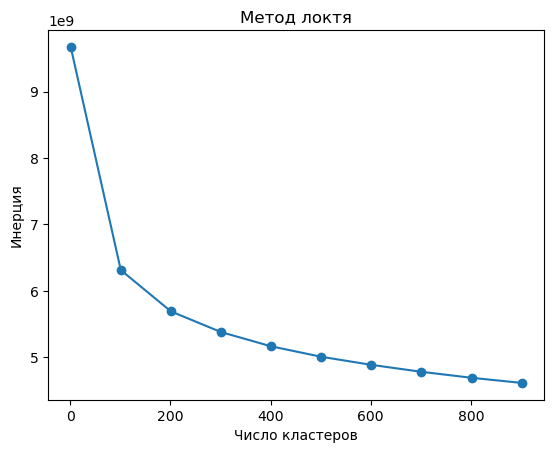

In [18]:
X = base.sample(n=100000, random_state=42)
inertia = []
for k in range(1, 1000,100):
    kmeans = KMeans(n_clusters=k,  n_init=10,random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

#Визуализация метода локтя
plt.plot(range(1, 1000,100), inertia, marker='o')
plt.title('Метод локтя')
plt.xlabel('Число кластеров')
plt.ylabel('Инерция')
plt.show()

## Разработка системы с помощью FAISS

**Train**

In [19]:
import faiss
import numpy as np

In [20]:
k = 200
dimension = base.shape[1]
quantizer = faiss.IndexFlatL2(dimension)

index = faiss.IndexFlatL2(dimension)
index.nprobe = 5
index.reset()
index.train(np.ascontiguousarray(base.values[:,:]).astype('float32'))
index.add(np.ascontiguousarray(base.values[:,:]).astype('float32'))
base_index = {k: v for k, v in enumerate(base.index.to_list())}
r, idx = index.search(np.ascontiguousarray(train.values).astype('float32'), 5)
acc = 0 

for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(100 * acc / len(idx))

69.638


на данном этапе я обучил faiss, каким образом подходят друг другу товары.

Почему l2? Он дает наилучшие результаты acc@5

**Validation**

In [21]:
validation_answer = validation_answer.drop('Id', axis = 1)
base_index = {k: v for k, v in enumerate(base.index.to_list())}
r, idx = index.search(np.ascontiguousarray(validation.values).astype('float32'), 5)
acc = 0
for target, el in zip(validation_answer['Expected'].values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(100 * acc / len(idx))

69.524


Очень неплохой результат acc@5

In [22]:
from IPython.display import Audio
import numpy as np

beep = np.sin(2*np.pi*400*np.arange(30000*2)/10000)
Audio(beep, rate=10000, autoplay=True)

**Итог:**
- Был проведен EDA признаков перед разработкой системы.
- Был проведен подсчет оптимального количества кластеров методом локтя.
- Был проведен выбор наилучшей модели для системы рекомендаций. Лучшая: FlatL2.
- Была обучена и протестирована система рекомендаций. Метрика на трейне: 69,6.
- Система была протестирована на валидационной выборке. Метрика на валидации: 69,5.